In [1]:
import re
import tensorflow as tf
from tensorflow import keras
from keras import layers
from pathlib import Path
from dataclasses import dataclass, field, replace, asdict
from typing import List, Optional
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
from IPython.display import display


@dataclass
class DataConfig:
    data_dir: str = "data/breakhis-dataset/binary/40X"
    img_size: int = 224
    batch_size: int = 32
    validation_split: float = 0.2
    seed: int = 123


@dataclass
class ModelConfig:
    backbone: str = "EfficientNetB0"
    pretrained: bool = True
    unfreeze_blocks: int = 1
    blocks_to_unfreeze: Optional[List[int]] = None
    dropout_rate: float = 0.2


@dataclass
class TrainingConfig:
    epochs: int = 10
    learning_rate: float = 1e-4
    optimizer: str = "Adam"
    loss: str = "binary_crossentropy"
    metrics: List[str] = field(default_factory=lambda: ["accuracy"])


@dataclass
class CallbackConfig:
    tensorboard_logdir: str = "logs/"
    checkpoint_dir: str = "checkpoints/"
    model_save_dir: str = "saved_models/"
    save_model: bool = False


@dataclass
class ExperimentConfig:
    data: DataConfig = field(default_factory=DataConfig)
    model: ModelConfig = field(default_factory=ModelConfig)
    training: TrainingConfig = field(default_factory=TrainingConfig)
    callbacks: CallbackConfig = field(default_factory=CallbackConfig)


def print_block(title: str, data: dict):
    labels = {
        k: (f"{v:.2f}" if isinstance(v, float) else str(v)) for k, v in data.items()
    }
    lbl_w = max(len(k) for k in labels)
    val_w = max(len(v) for v in labels.values())
    total_w = lbl_w + 2 + val_w + 2
    title_str = f" {title} "
    border = "=" * max(len(title_str), total_w)
    print(f"\n{border}")
    print(title_str.center(len(border)))
    print(border)
    for k, v in labels.items():
        print(f"{k.ljust(lbl_w)} : {v.rjust(val_w)}")
    print(border + "\n")


def summarize_model(base):
    block_layers = {}
    block_trainable = {}
    for layer in base.layers:
        m = re.match(r"^block(\d+)[a-z]?_", layer.name)
        blk = int(m.group(1)) if m else 0
        block_layers[blk] = block_layers.get(blk, 0) + 1
        block_trainable[blk] = block_trainable.get(blk, False) or layer.trainable
    rows = []
    for blk in sorted(block_layers):
        name = f"block{blk}" if blk > 0 else "stem/head"
        rows.append(
            (name, str(block_layers[blk]), "Yes" if block_trainable[blk] else "No")
        )
    headers = ("Block", "Layers", "Trainable")
    col1 = max(len(r[0]) for r in rows + [headers])
    col2 = max(len(r[1]) for r in rows + [headers])
    col3 = max(len(r[2]) for r in rows + [headers])
    total_w = col1 + col2 + col3 + 6
    border = "=" * total_w
    print(f"\n{border}")
    print(
        f"{headers[0].ljust(col1)} | {headers[1].rjust(col2)} | {headers[2].rjust(col3)}"
    )
    print(border)
    for name, cnt, tf in rows:
        print(f"{name.ljust(col1)} | {cnt.rjust(col2)} | {tf.rjust(col3)}")
    print(border + "\n")


def prepare_dataset(cfg: ExperimentConfig):
    dc = cfg.data
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        dc.data_dir,
        labels="inferred",
        label_mode="binary",
        batch_size=dc.batch_size,
        image_size=(dc.img_size, dc.img_size),
        validation_split=dc.validation_split,
        subset="training",
        seed=dc.seed,
    )
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        dc.data_dir,
        labels="inferred",
        label_mode="binary",
        batch_size=dc.batch_size,
        image_size=(dc.img_size, dc.img_size),
        validation_split=dc.validation_split,
        subset="validation",
        seed=dc.seed,
    )
    return train_ds.prefetch(tf.data.AUTOTUNE), val_ds.prefetch(tf.data.AUTOTUNE)


def build_model(cfg: ExperimentConfig):
    mc = cfg.model
    img_size = cfg.data.img_size
    base = getattr(keras.applications, mc.backbone)(
        include_top=False,
        weights="imagenet" if mc.pretrained else None,
        input_shape=(img_size, img_size, 3),
    )
    block_nums = {
        int(m.group(1))
        for layer in base.layers
        if (m := re.match(r"^block(\d+)[a-z]?_", layer.name))
    }
    unique_blocks = sorted(block_nums)
    if mc.blocks_to_unfreeze:
        target_blocks = mc.blocks_to_unfreeze
    else:
        target_blocks = unique_blocks[-mc.unfreeze_blocks :]
    for layer in base.layers:
        m = re.match(r"^block(\d+)[a-z]?_", layer.name)
        freeze = not (
            m
            and int(m.group(1)) in target_blocks
            and not isinstance(layer, layers.BatchNormalization)
        )
        layer.trainable = not freeze
    inp = keras.Input((img_size, img_size, 3))
    x = base(inp, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(mc.dropout_rate)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inp, out)
    return model, base


def compile_and_train(model: keras.Model, train_ds, val_ds, cfg: ExperimentConfig):
    tc = cfg.training
    cb = cfg.callbacks
    opt = getattr(keras.optimizers, tc.optimizer)(learning_rate=tc.learning_rate)
    model.compile(optimizer=opt, loss=tc.loss, metrics=tc.metrics)
    callbacks = []
    if cb.tensorboard_logdir:
        callbacks.append(keras.callbacks.TensorBoard(log_dir=cb.tensorboard_logdir))
    if cb.checkpoint_dir:
        p = Path(cb.checkpoint_dir)
        p.mkdir(parents=True, exist_ok=True)
        callbacks.append(
            keras.callbacks.ModelCheckpoint(
                filepath=str(p / "ckpt_{epoch}.keras"),
                save_best_only=True,
                monitor="val_loss",
            )
        )
    return model.fit(
        train_ds, validation_data=val_ds, epochs=tc.epochs, callbacks=callbacks
    )


def plot_history(history):
    hist = history.history
    epochs = range(1, len(hist["loss"]) + 1)
    plt.figure()
    plt.plot(epochs, hist["loss"], label="Training Loss")
    plt.plot(epochs, hist["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    if "accuracy" in hist:
        plt.figure()
        plt.plot(epochs, hist["accuracy"], label="Training Accuracy")
        plt.plot(epochs, hist["val_accuracy"], label="Validation Accuracy")
        plt.title("Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()


def report_results(model: keras.Model, val_ds):
    try:
        y_true, y_pred = [], []
        for x_batch, y_batch in val_ds.unbatch().batch(1024):
            preds = (model.predict(x_batch) > 0.5).astype(int).flatten()
            y_true.extend(y_batch.numpy().astype(int))
            y_pred.extend(preds.tolist())
        print("\nClassification Report:\n")
        print(classification_report(y_true, y_pred, digits=4))
    except Exception as e:
        print(f"\nCould not compute classification report: {e}")


def run_experiment(experiment_name: str = "experiment", **overrides):
    cfg = ExperimentConfig()
    for section, params in overrides.items():
        if hasattr(cfg, section) and isinstance(params, dict):
            old = getattr(cfg, section)
            new = replace(old, **params)
            cfg = replace(cfg, **{section: new})
        else:
            raise ValueError(f'Unknown section "{section}" or invalid params')
    cfg_dict = {}
    flat = asdict(cfg)
    for sec, sec_vals in flat.items():
        for k, v in sec_vals.items():
            cfg_dict[f"{sec}.{k}"] = v
    print_block("Experiment Config", cfg_dict)
    train_ds, val_ds = prepare_dataset(cfg)
    model, base = build_model(cfg)
    summarize_model(base)
    history = compile_and_train(model, train_ds, val_ds, cfg)
    plot_history(history)
    report_results(model, val_ds)
    if cfg.callbacks.save_model:
        save_path = Path(cfg.callbacks.model_save_dir)
        save_path.mkdir(parents=True, exist_ok=True)
        model.save(save_path / f"{experiment_name}.keras")
    return {"history": history, "model": model}


PREFIX_MAP = [
    ("baseline", "Baseline"),
    ("block", "Blocks"),
    ("lr", "Learning Rate"),
    ("optimizer", "Optimizers"),
    ("dropout", "Dropouts"),
    ("batchsize", "Batch Sizes"),
    ("mag", "Magnification")
]


def categorize(key):
    for pfx, label in PREFIX_MAP:
        if key.startswith(pfx):
            return label
    return "Other"


def report_experiments(exp: dict, alpha: float = 0.25):
    rows = []
    for name, res in exp.items():
        hist = res["history"].history
        val_loss = hist["val_loss"]
        train_loss = hist["loss"]
        val_acc = hist.get("val_accuracy")
        best_idx = int(pd.Series(val_loss).idxmin())
        rows.append(
            {
                "Experiment": name,
                "Category": categorize(name),
                "Validation Accuracy": val_acc[best_idx],
                "Validation Loss": val_loss[best_idx],
                "Overfit Gap": val_loss[best_idx] - train_loss[best_idx],
            }
        )
    df = pd.DataFrame(rows)
    df["NormLoss"] = df.groupby("Category")["Validation Loss"].transform(
        lambda s: (s - s.min()) / (s.max() - s.min()) if s.max() != s.min() else 0.0
    )
    df["NormGap"] = df.groupby("Category")["Overfit Gap"].transform(
        lambda s: (s - s.min()) / (s.max() - s.min()) if s.max() != s.min() else 0.0
    )
    df["Score"] = alpha * (1 - df["NormLoss"]) + (1 - alpha) * (1 - df["NormGap"])
    display(df.drop(columns=["NormGap"]).round(4))
    best = df.loc[df["Score"].idxmax()]
    best_by_cat = (
        df.sort_values("Score", ascending=False)
        .groupby("Category", as_index=False)
        .first()[
            [
                "Category",
                "Experiment",
                "Validation Accuracy",
                "Validation Loss",
                "Overfit Gap",
            ]
        ]
    )
    display(best_by_cat.round(4))

2025-05-16 03:01:14.028486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747335674.087588   61104 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747335674.105622   61104 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747335674.215678   61104 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747335674.215710   61104 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747335674.215712   61104 computation_placer.cc:177] computation placer alr

In [2]:
exp = {}

## Magnifications


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     :                             None
model.dropout_rate           :                             0.20
training.epochs              :                               10
training.learning_rate       :                             0.00
training.optimizer           :                             Adam
training.loss                :              binary_crossentropy
training.metrics             :        

I0000 00:00:1747333159.666593   31774 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4084 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:0b:00.0, compute capability: 7.5


Found 1995 files belonging to 2 classes.
Using 399 files for validation.

Block     | Layers | Trainable
stem/head |     11 |        No
block1    |     10 |        No
block2    |     29 |        No
block3    |     29 |        No
block4    |     44 |        No
block5    |     43 |        No
block6    |     59 |        No
block7    |     13 |       Yes

Epoch 1/10


I0000 00:00:1747333170.135619   31864 service.cc:152] XLA service 0x7f593004ea20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747333170.135658   31864 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2025-05-16 02:19:30.386423: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747333171.522814   31864 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/50 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3212 - loss: 0.8824  

I0000 00:00:1747333179.153354   31864 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 363ms/step - accuracy: 0.5971 - loss: 0.6696 - val_accuracy: 0.7519 - val_loss: 0.4690
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8185 - loss: 0.4128 - val_accuracy: 0.8571 - val_loss: 0.3105
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8904 - loss: 0.2953 - val_accuracy: 0.9223 - val_loss: 0.2226
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9219 - loss: 0.2194 - val_accuracy: 0.9323 - val_loss: 0.1789
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9322 - loss: 0.1992 - val_accuracy: 0.9398 - val_loss: 0.1505
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9484 - loss: 0.1521 - val_accuracy: 0.9499 - val_loss: 0.1251
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9642 - loss: 0.1233 - val_accuracy: 0.9524 - val_loss: 0.1165
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9714 - loss: 0.0926 - val_accuracy: 0.9574 - val_loss: 

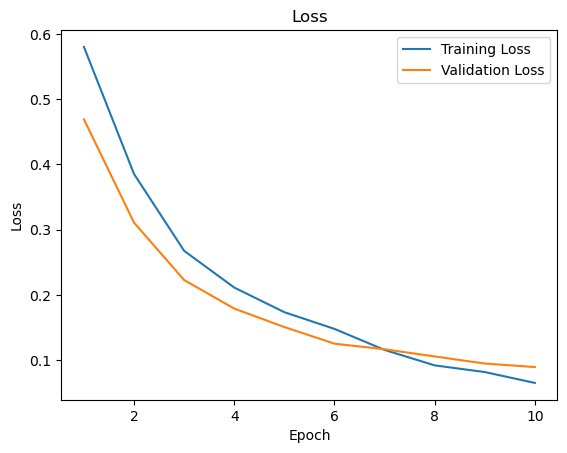

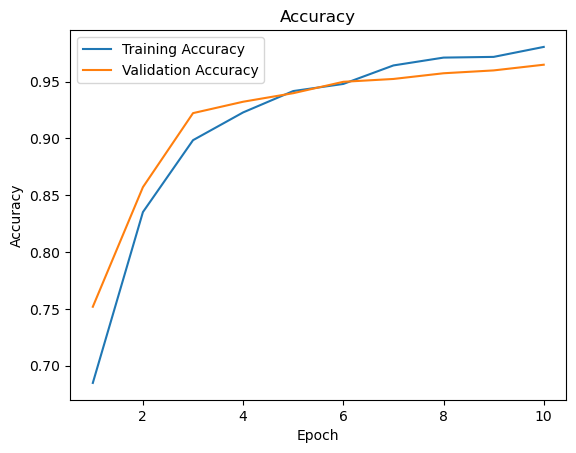

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 290ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9840    0.9111    0.9462       135
           1     0.9562    0.9924    0.9740       264

    accuracy                         0.9649       399
   macro avg     0.9701    0.9518    0.9601       399
weighted avg     0.9656    0.9649    0.9646       399



2025-05-16 02:20:26.622006: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



                        Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/100X
data.img_size                :                               224
data.batch_size              :                                32
data.validation_split        :                              0.20
data.seed                    :                               123
model.backbone               :                    EfficientNetB0
model.pretrained             :                              True
model.unfreeze_blocks        :                                 1
model.blocks_to_unfreeze     :                              None
model.dropout_rate           :                              0.20
training.epochs              :                                10
training.learning_rate       :                              0.00
training.optimizer           :                              Adam
training.loss                :               binary_crossentropy
training.metrics       

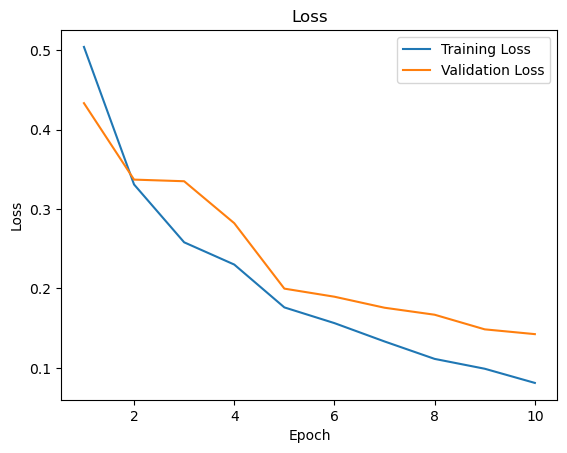

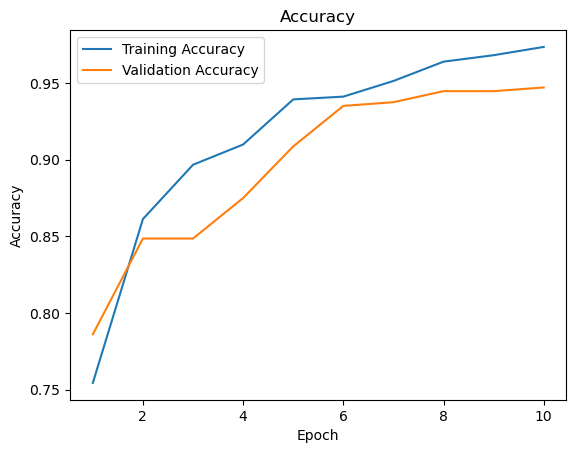

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9538    0.8857    0.9185       140
           1     0.9441    0.9783    0.9609       276

    accuracy                         0.9471       416
   macro avg     0.9490    0.9320    0.9397       416
weighted avg     0.9474    0.9471    0.9466       416



2025-05-16 02:21:24.229433: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



                        Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/200X
data.img_size                :                               224
data.batch_size              :                                32
data.validation_split        :                              0.20
data.seed                    :                               123
model.backbone               :                    EfficientNetB0
model.pretrained             :                              True
model.unfreeze_blocks        :                                 1
model.blocks_to_unfreeze     :                              None
model.dropout_rate           :                              0.20
training.epochs              :                                10
training.learning_rate       :                              0.00
training.optimizer           :                              Adam
training.loss                :               binary_crossentropy
training.metrics       

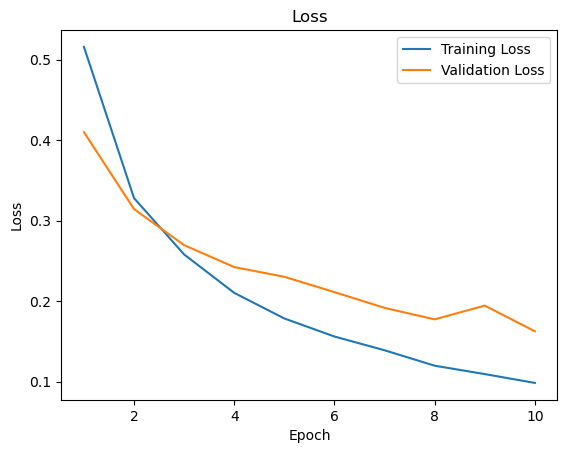

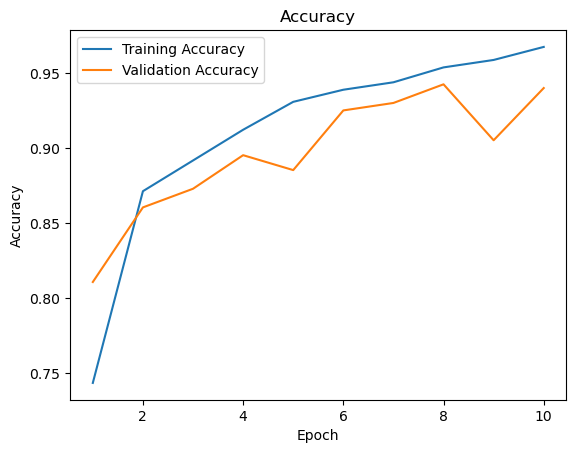

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 306ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9051    0.9185    0.9118       135
           1     0.9585    0.9513    0.9549       267

    accuracy                         0.9403       402
   macro avg     0.9318    0.9349    0.9333       402
weighted avg     0.9406    0.9403    0.9404       402


                        Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/400X
data.img_size                :                               224
data.batch_size              :                                32
data.validation_split        :                              0.20
data.seed                    :                               123
model.backbone               :                    EfficientNetB0
model.pretrained             :                              True
model.unfreeze_blocks        :                                 1
model.blocks_to_unfr

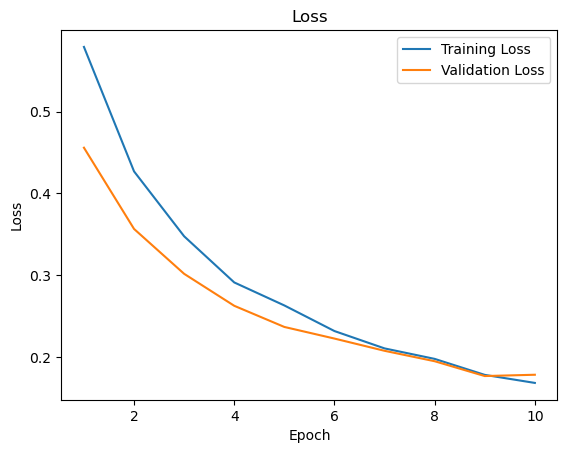

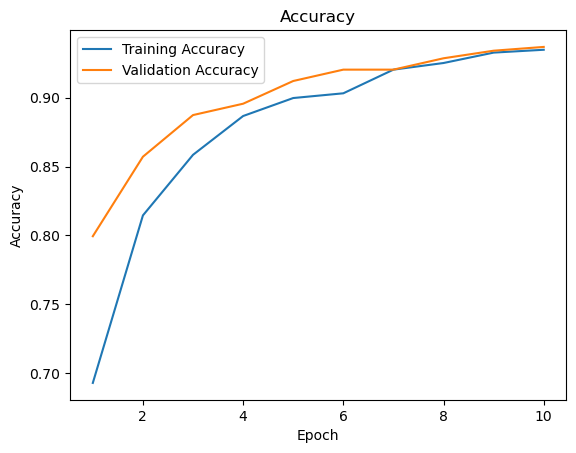

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 330ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.8952    0.9174    0.9061       121
           1     0.9583    0.9465    0.9524       243

    accuracy                         0.9368       364
   macro avg     0.9267    0.9319    0.9293       364
weighted avg     0.9373    0.9368    0.9370       364



2025-05-16 02:23:34.758224: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [3]:
for mag in [40, 100, 200, 400]:
    exp[f"mag_{mag}"] = run_experiment(
        data={"data_dir": f"data/breakhis-dataset/binary/{mag}X"}, 
        callbacks={"save_model": True}
    )

## Baseline
This will be used for comparison


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     :                             None
model.dropout_rate           :                             0.20
training.epochs              :                               10
training.learning_rate       :                             0.00
training.optimizer           :                             Adam
training.loss                :              binary_crossentropy
training.metrics             :        

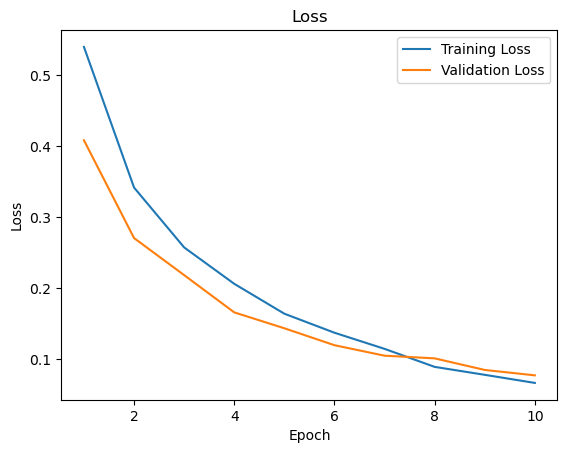

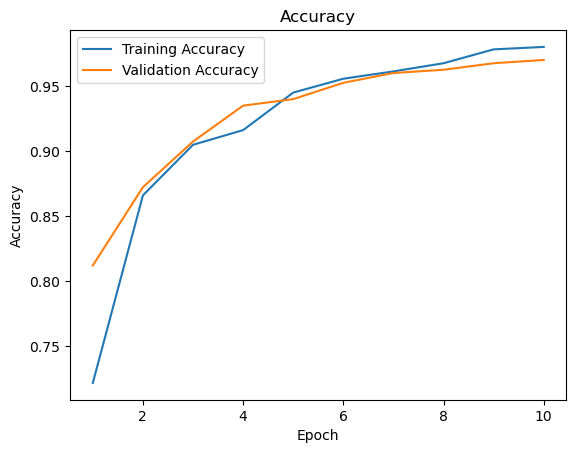

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 301ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9767    0.9333    0.9545       135
           1     0.9667    0.9886    0.9775       264

    accuracy                         0.9699       399
   macro avg     0.9717    0.9610    0.9660       399
weighted avg     0.9701    0.9699    0.9698       399



In [5]:
exp['baseline'] = run_experiment(experiment_name='baseline')

## Blocks
-  Earlier layers tend to learn very general features
-  Later blocks capture more specialized patterns

Fine-tune varying depths by testing it empirically to identify which one will work the best for our dataset.


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                6
model.blocks_to_unfreeze     :                             None
model.dropout_rate           :                             0.20
training.epochs              :                               10
training.learning_rate       :                             0.00
training.optimizer           :                             Adam
training.loss                :              binary_crossentropy
training.metrics             :        

2025-05-16 02:25:03.490753: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-16 02:25:03.697162: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-16 02:25:03.907341: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-16 02:25:04.119573: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-16 02:25:04.249674: E external/local_xla/xla/service

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7680 - loss: 0.4574

2025-05-16 02:25:25.403784: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng18{k11=0} for conv %cudnn-conv-bw-filter.65 = (f32[480,1,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[28,480,14,14]{3,2,1,0} %bitcast.59327, f32[28,480,14,14]{3,2,1,0} %bitcast.59329), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=480, custom_call_target="__cudnn$convBackwardFilter", metadata={op_type="DepthwiseConv2dNativeBackpropFilter" op_name="gradient_tape/functional_5_1/efficientnetb0_1/block4b_dwconv_1/depthwise/DepthwiseConv2dNativeBackpropFilter" source_file="/home/johnny/miniconda3/envs/machine-learning/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-05-16 02:2

50/50 ━━━━━━━━━━━━━━━━━━━━ 62s 627ms/step - accuracy: 0.7709 - loss: 0.4528 - val_accuracy: 0.9198 - val_loss: 0.1965
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9398 - loss: 0.1590 - val_accuracy: 0.9724 - val_loss: 0.0583
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.9765 - loss: 0.0574 - val_accuracy: 0.9875 - val_loss: 0.0354
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.9684 - loss: 0.0752 - val_accuracy: 0.9900 - val_loss: 0.0312
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.9918 - loss: 0.0285 - val_accuracy: 0.9925 - val_loss: 0.0224
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.9952 - loss: 0.0197 - val_accuracy: 0.9674 - val_loss: 0.0824
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.9865 - loss: 0.0284 - val_accuracy: 0.9850 - val_loss: 0.0353
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.9986 - loss: 0.0051 - val_accuracy: 0.9925 - val_lo

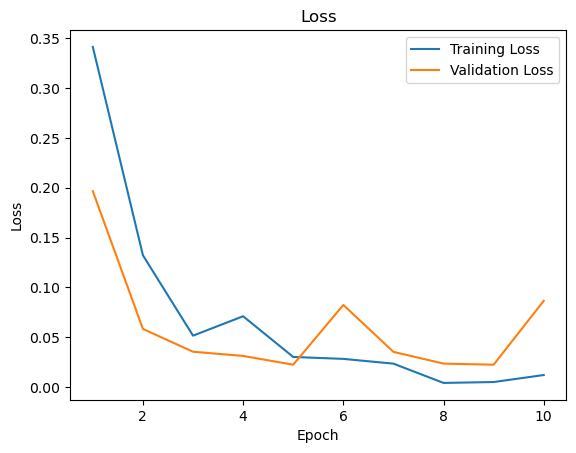

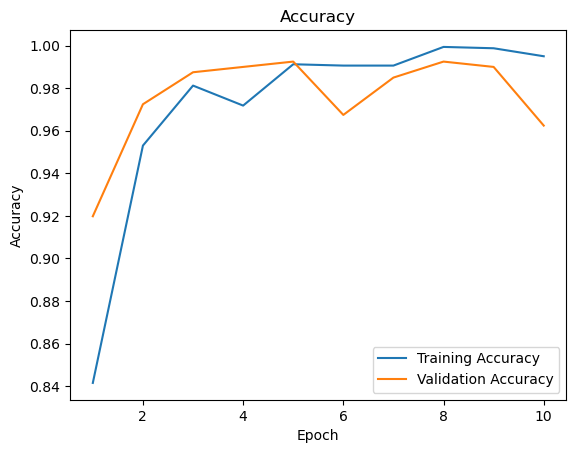

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 302ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9054    0.9926    0.9470       135
           1     0.9960    0.9470    0.9709       264

    accuracy                         0.9624       399
   macro avg     0.9507    0.9698    0.9589       399
weighted avg     0.9654    0.9624    0.9628       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                5
model.blocks_to_unfreeze     

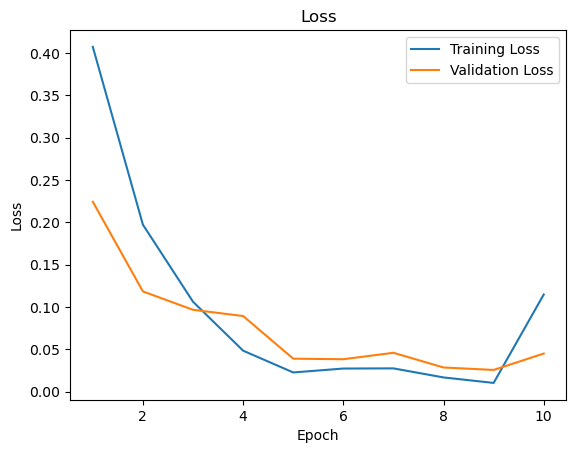

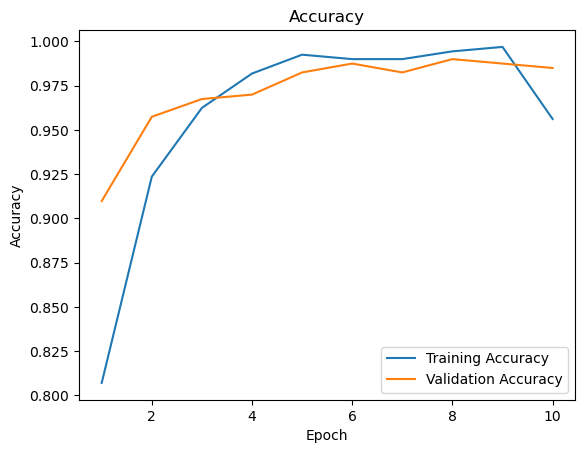

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 297ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9924    0.9630    0.9774       135
           1     0.9813    0.9962    0.9887       264

    accuracy                         0.9850       399
   macro avg     0.9869    0.9796    0.9831       399
weighted avg     0.9851    0.9850    0.9849       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                4
model.blocks_to_unfreeze     

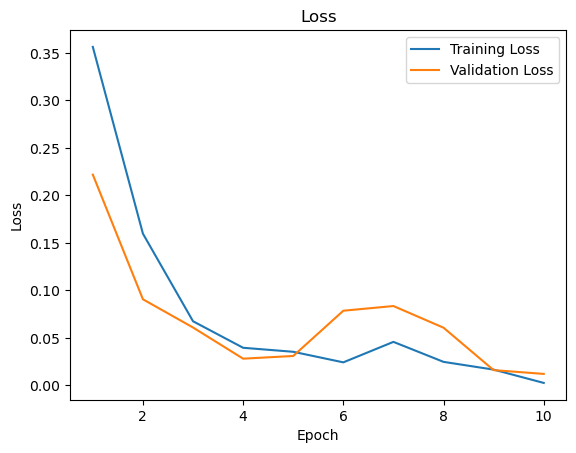

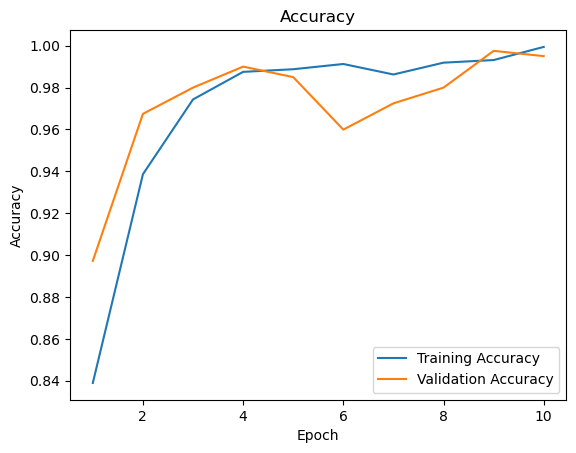

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 295ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9926    0.9926    0.9926       135
           1     0.9962    0.9962    0.9962       264

    accuracy                         0.9950       399
   macro avg     0.9944    0.9944    0.9944       399
weighted avg     0.9950    0.9950    0.9950       399



2025-05-16 02:29:39.007583: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
for b in [6, 5, 4]:
    exp[f'block_{b}'] = run_experiment(
        experiment_name=f'block_{b}',
        model={'unfreeze_blocks': b},
        callbacks={"save_model": True},
    )


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                3
model.blocks_to_unfreeze     :                             None
model.dropout_rate           :                             0.20
training.epochs              :                               10
training.learning_rate       :                             0.00
training.optimizer           :                             Adam
training.loss                :              binary_crossentropy
training.metrics             :        

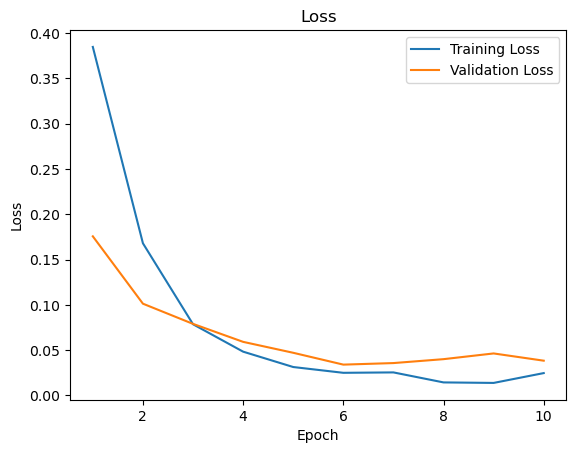

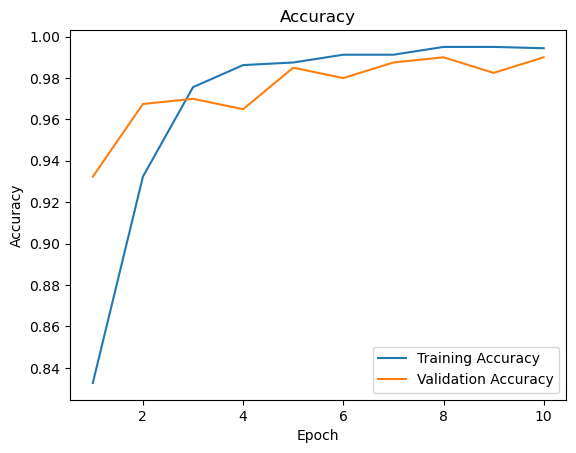

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 296ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9925    0.9778    0.9851       135
           1     0.9887    0.9962    0.9925       264

    accuracy                         0.9900       399
   macro avg     0.9906    0.9870    0.9888       399
weighted avg     0.9900    0.9900    0.9900       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                2
model.blocks_to_unfreeze     

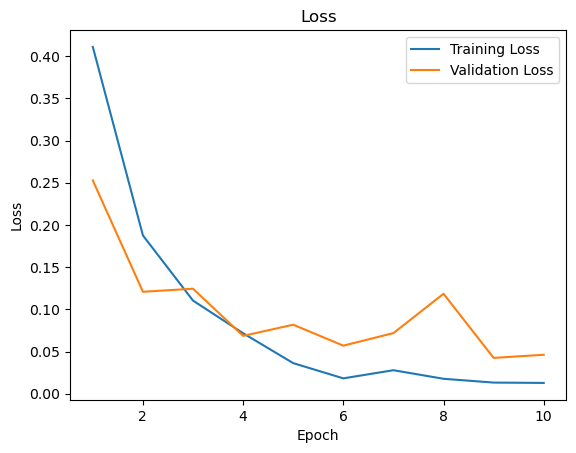

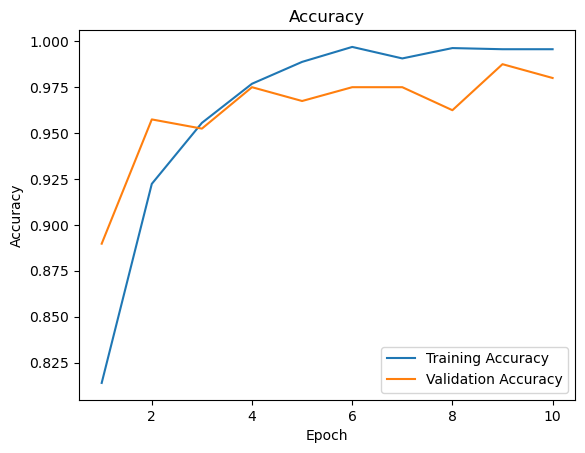

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 294ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9704    0.9704    0.9704       135
           1     0.9848    0.9848    0.9848       264

    accuracy                         0.9799       399
   macro avg     0.9776    0.9776    0.9776       399
weighted avg     0.9799    0.9799    0.9799       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

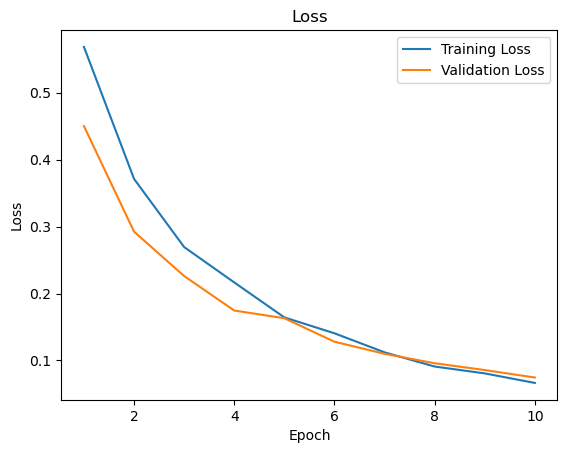

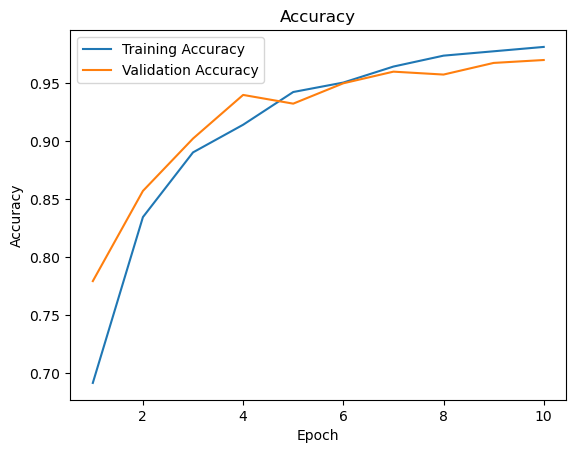

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 297ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9843    0.9259    0.9542       135
           1     0.9632    0.9924    0.9776       264

    accuracy                         0.9699       399
   macro avg     0.9737    0.9592    0.9659       399
weighted avg     0.9703    0.9699    0.9697       399



In [7]:
for b in [3, 2, 1]:
    exp[f'block_{b}'] = run_experiment(
        experiment_name=f'block_{b}',
        model={'unfreeze_blocks': b},
        callbacks={"save_model": True},
    )

## Learning Rates
Balance fast convergence against stability
- Too high a rate can skip over minima
- Too low may cause painfully slow training or getting stuck in poor local minima


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     :                             None
model.dropout_rate           :                             0.20
training.epochs              :                               10
training.learning_rate       :                             0.00
training.optimizer           :                             Adam
training.loss                :              binary_crossentropy
training.metrics             :        

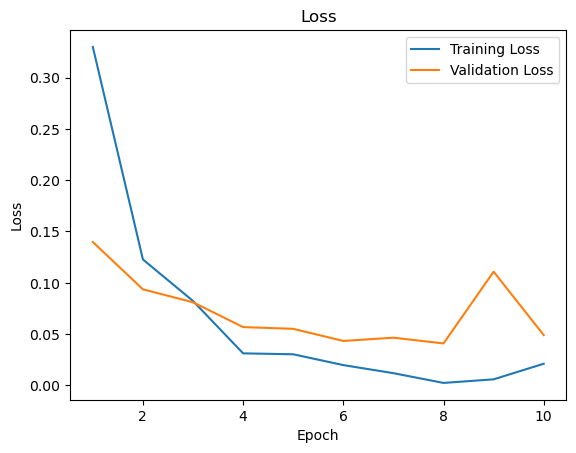

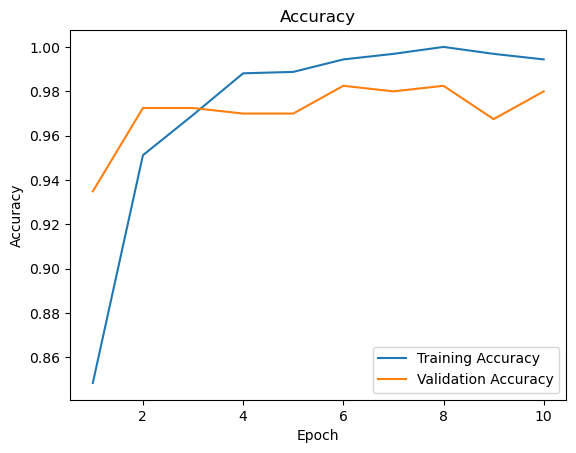

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 300ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9635    0.9778    0.9706       135
           1     0.9885    0.9811    0.9848       264

    accuracy                         0.9799       399
   macro avg     0.9760    0.9794    0.9777       399
weighted avg     0.9801    0.9799    0.9800       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

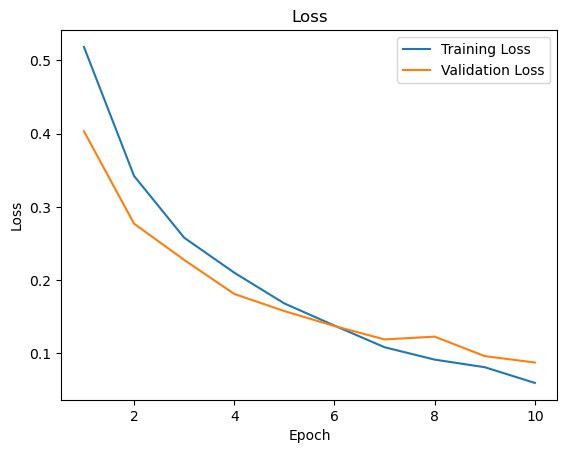

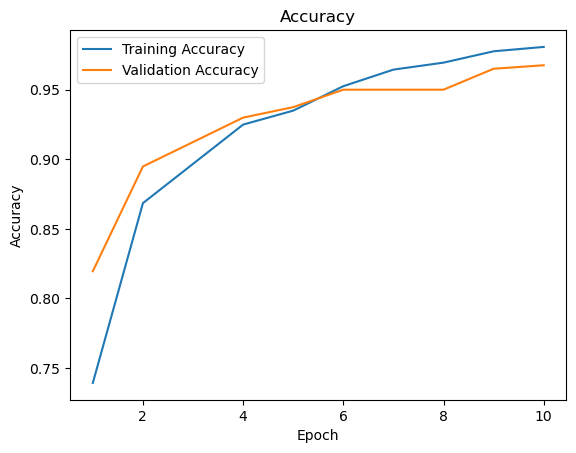

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 306ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9621    0.9407    0.9513       135
           1     0.9700    0.9811    0.9755       264

    accuracy                         0.9674       399
   macro avg     0.9661    0.9609    0.9634       399
weighted avg     0.9674    0.9674    0.9673       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

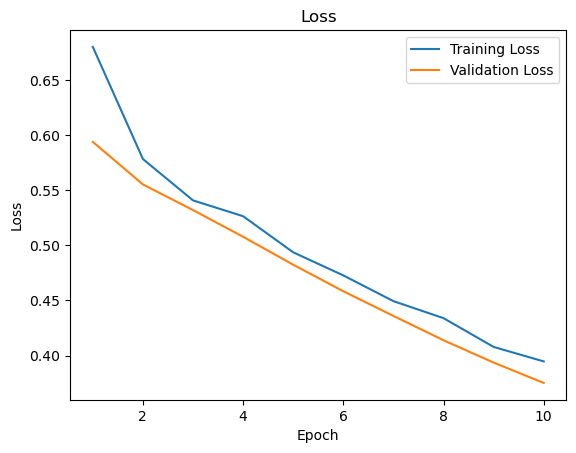

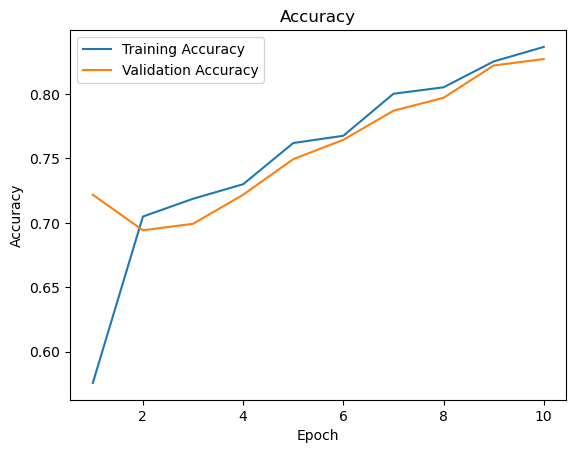

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 304ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.8587    0.5852    0.6960       135
           1     0.8176    0.9508    0.8792       264

    accuracy                         0.8271       399
   macro avg     0.8381    0.7680    0.7876       399
weighted avg     0.8315    0.8271    0.8172       399



In [8]:
for lr in [1e-3, 1e-4, 1e-5]:
    exp[f'lr_{lr}'] = run_experiment(
        experiment_name=f'lr_{lr}',
        training={'learning_rate': lr},
        callbacks={"save_model": True},
    )

## Optimizer Variations
Different optimizers to assess optimization dynamics.


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     :                             None
model.dropout_rate           :                             0.20
training.epochs              :                               10
training.learning_rate       :                             0.00
training.optimizer           :                              SGD
training.loss                :              binary_crossentropy
training.metrics             :        

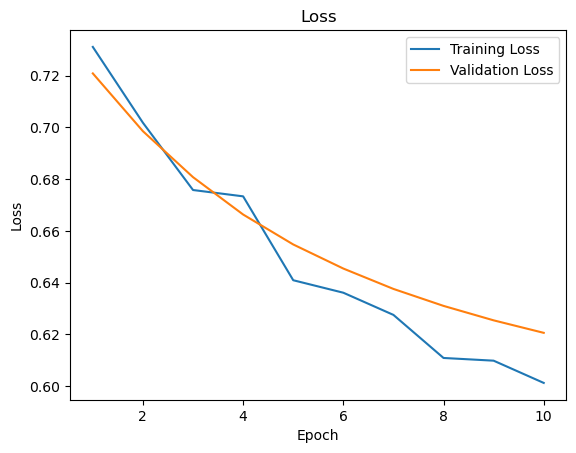

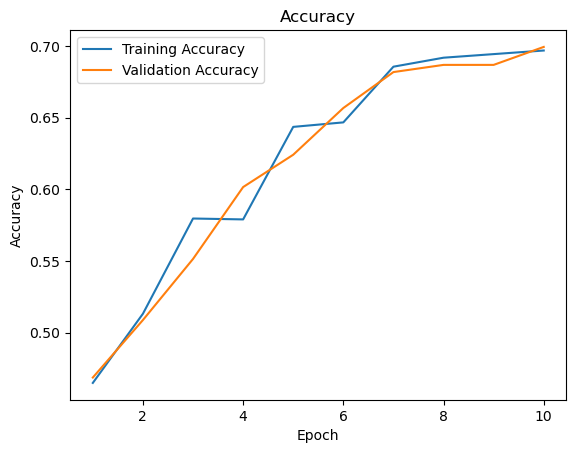

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 330ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.7273    0.1778    0.2857       135
           1     0.6967    0.9659    0.8095       264

    accuracy                         0.6992       399
   macro avg     0.7120    0.5718    0.5476       399
weighted avg     0.7071    0.6992    0.6323       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

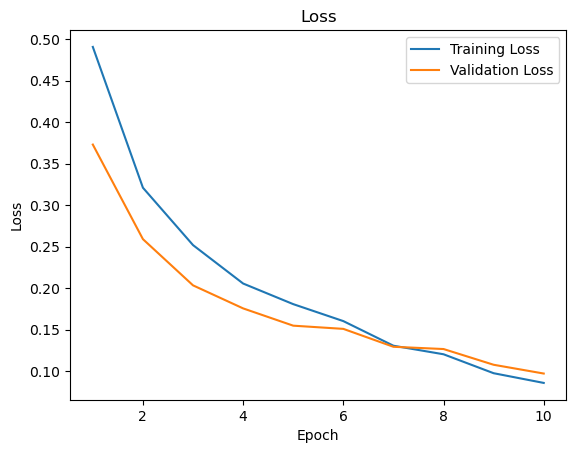

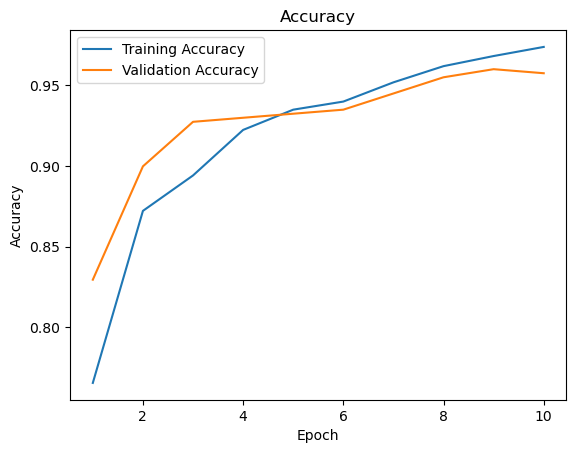

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 291ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9538    0.9185    0.9358       135
           1     0.9591    0.9773    0.9681       264

    accuracy                         0.9574       399
   macro avg     0.9565    0.9479    0.9520       399
weighted avg     0.9573    0.9574    0.9572       399



2025-05-16 02:38:15.698857: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     :                             None
model.dropout_rate           :                             0.20
training.epochs              :                               10
training.learning_rate       :                             0.00
training.optimizer           :                          Adagrad
training.loss                :              binary_crossentropy
training.metrics             :        

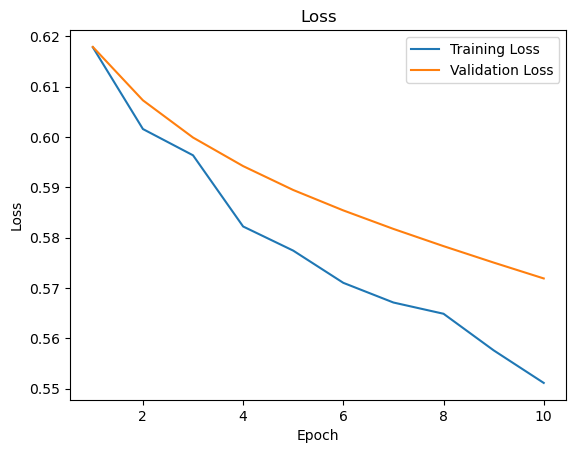

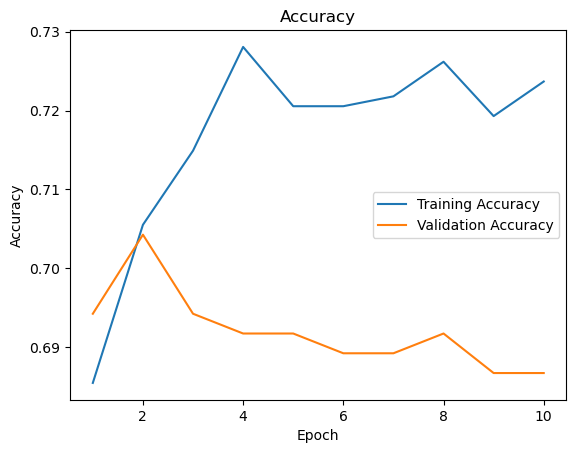

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 292ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.8571    0.0889    0.1611       135
           1     0.6805    0.9924    0.8074       264

    accuracy                         0.6867       399
   macro avg     0.7688    0.5407    0.4842       399
weighted avg     0.7403    0.6867    0.5887       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

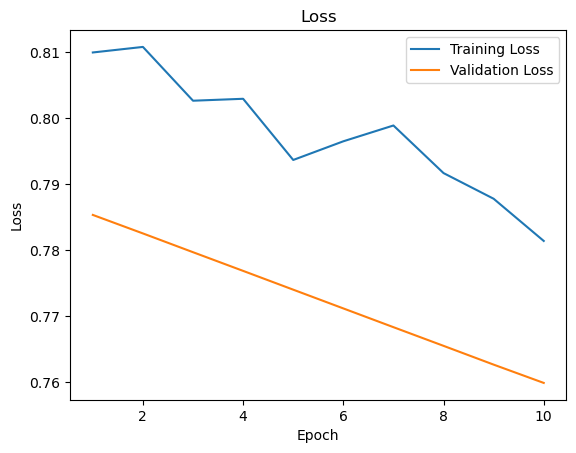

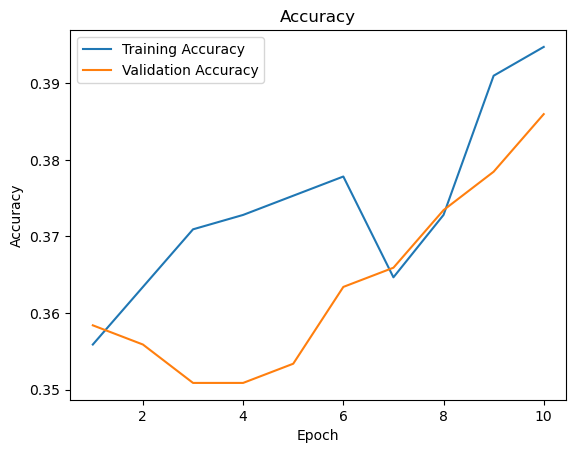

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 292ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.3050    0.6370    0.4125       135
           1     0.5812    0.2576    0.3570       264

    accuracy                         0.3860       399
   macro avg     0.4431    0.4473    0.3847       399
weighted avg     0.4877    0.3860    0.3757       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

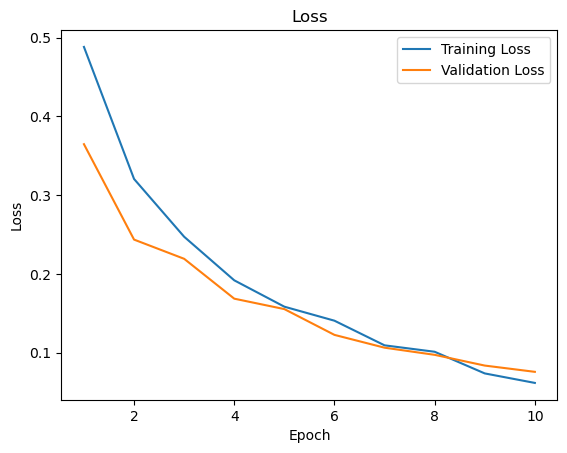

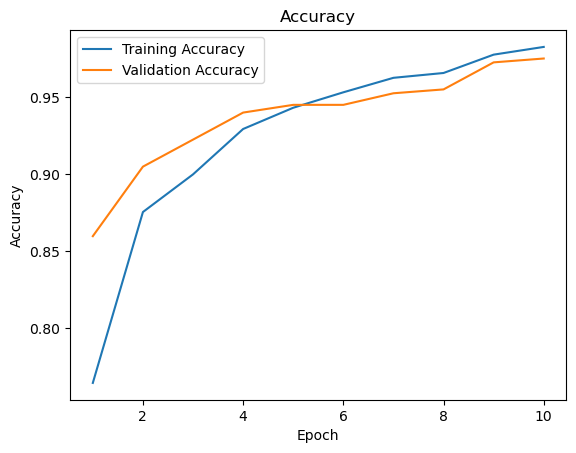

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 290ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9630    0.9630    0.9630       135
           1     0.9811    0.9811    0.9811       264

    accuracy                         0.9749       399
   macro avg     0.9720    0.9720    0.9720       399
weighted avg     0.9749    0.9749    0.9749       399



In [9]:
for opt in ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam']:
    exp[f'optimizer_{opt}'] = run_experiment(
        experiment_name=f'optimizer_{opt}',
        training={'optimizer': opt},
        callbacks={"save_model": True},
    )

## Dropouts
To find the balance between robustness and capacity
- Lower rates: make training more stable but might under-regularize
- higher rates: inject more noise to prevent co-adaptation of filters and combat overfitting


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     :                             None
model.dropout_rate           :                             0.20
training.epochs              :                               10
training.learning_rate       :                             0.00
training.optimizer           :                             Adam
training.loss                :              binary_crossentropy
training.metrics             :        

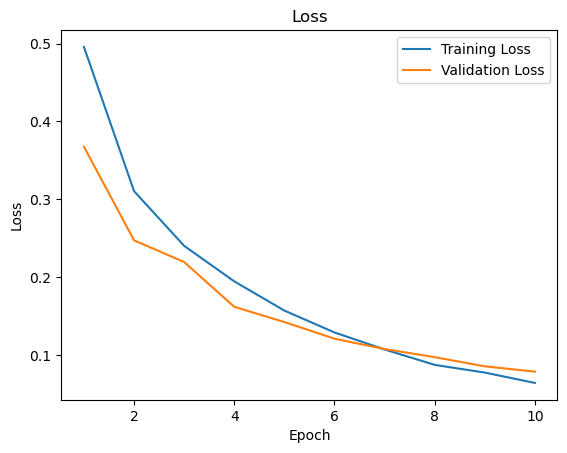

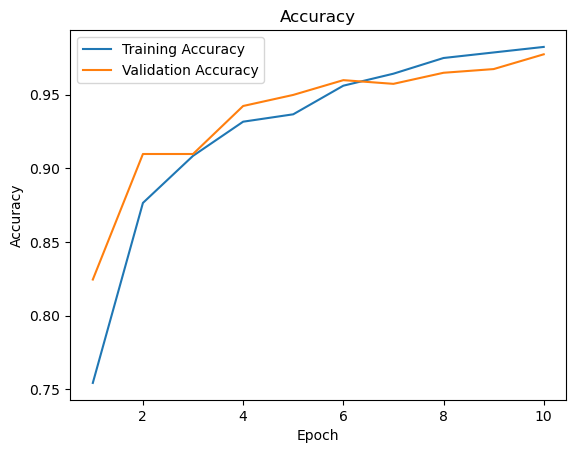

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 293ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9773    0.9556    0.9663       135
           1     0.9775    0.9886    0.9831       264

    accuracy                         0.9774       399
   macro avg     0.9774    0.9721    0.9747       399
weighted avg     0.9774    0.9774    0.9774       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

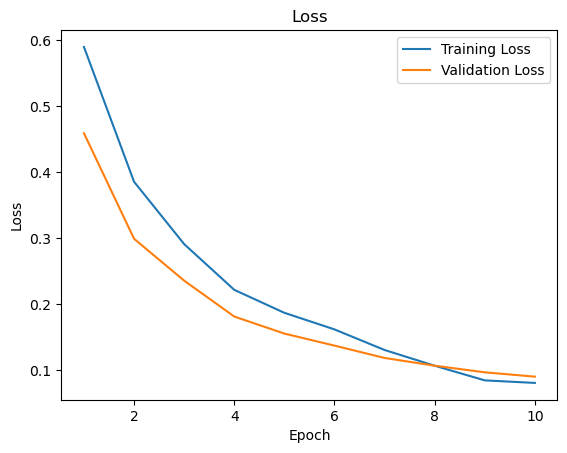

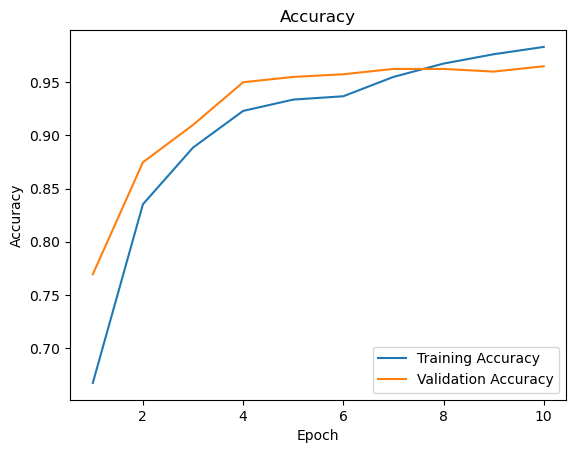

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 301ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9549    0.9407    0.9478       135
           1     0.9699    0.9773    0.9736       264

    accuracy                         0.9649       399
   macro avg     0.9624    0.9590    0.9607       399
weighted avg     0.9648    0.9649    0.9648       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

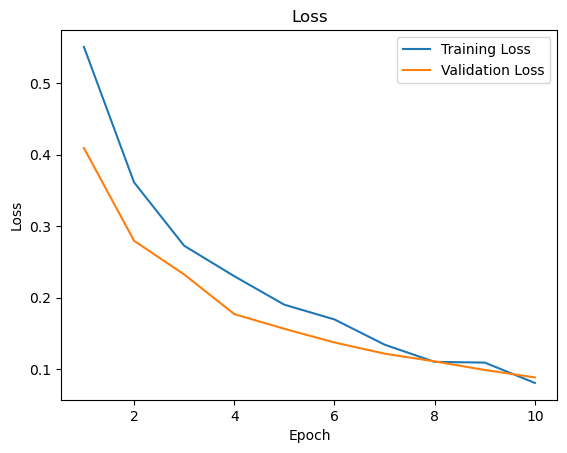

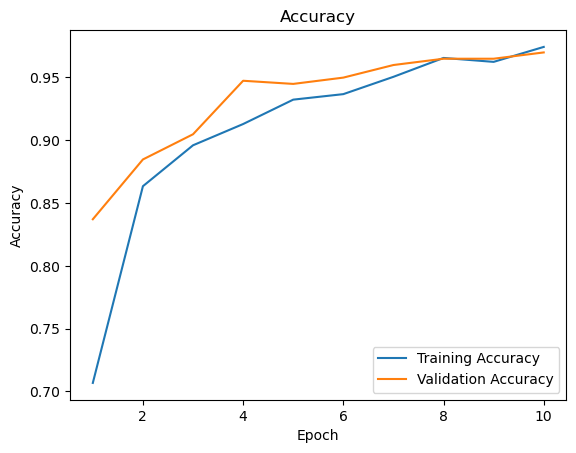

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 300ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9556    0.9556    0.9556       135
           1     0.9773    0.9773    0.9773       264

    accuracy                         0.9699       399
   macro avg     0.9664    0.9664    0.9664       399
weighted avg     0.9699    0.9699    0.9699       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

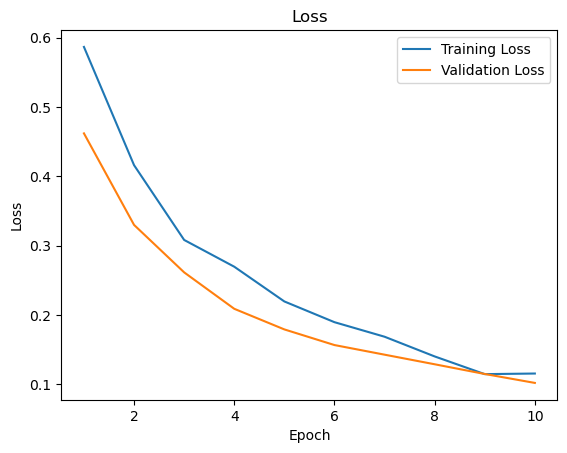

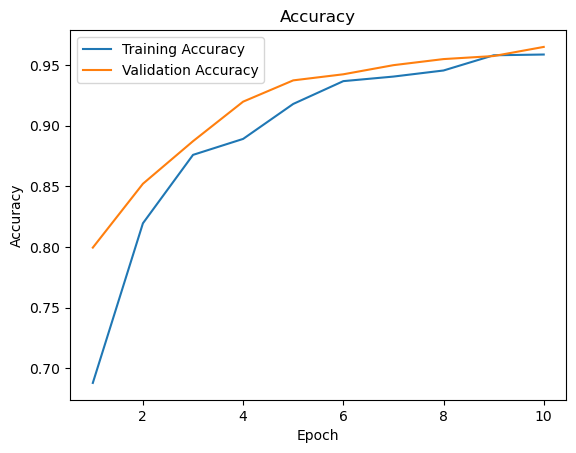

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 304ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9690    0.9259    0.9470       135
           1     0.9630    0.9848    0.9738       264

    accuracy                         0.9649       399
   macro avg     0.9660    0.9554    0.9604       399
weighted avg     0.9650    0.9649    0.9647       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

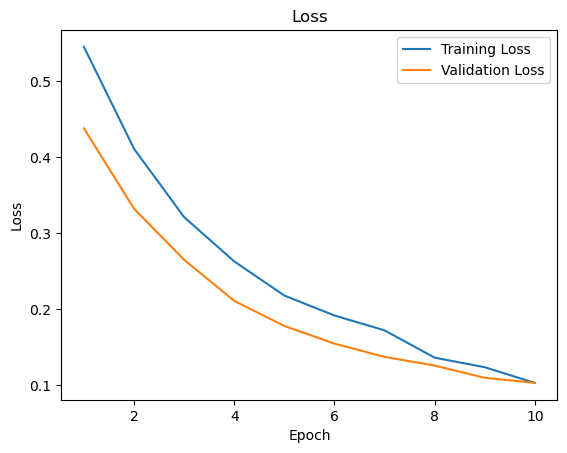

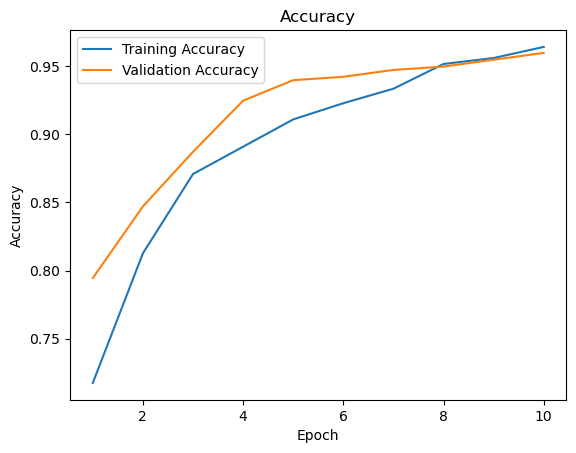

2025-05-16 02:46:20.399091: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 240244284 bytes after encountering the first element of size 240244284 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 304ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9612    0.9185    0.9394       135
           1     0.9593    0.9811    0.9700       264

    accuracy                         0.9599       399
   macro avg     0.9602    0.9498    0.9547       399
weighted avg     0.9599    0.9599    0.9597       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

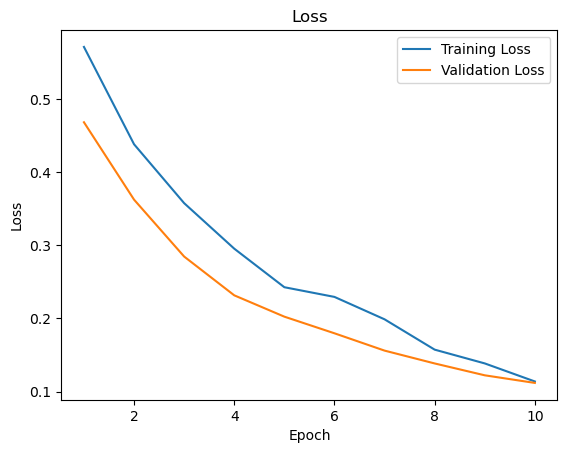

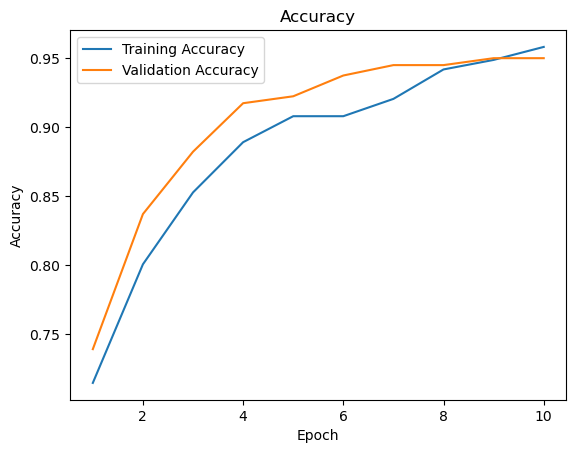

2025-05-16 02:47:22.851347: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 240244284 bytes after encountering the first element of size 240244284 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 308ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9600    0.8889    0.9231       135
           1     0.9453    0.9811    0.9628       264

    accuracy                         0.9499       399
   macro avg     0.9526    0.9350    0.9430       399
weighted avg     0.9502    0.9499    0.9494       399



In [10]:
for dr in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    exp[f'dropout_{dr}'] = run_experiment(
        experiment_name=f'dropout_{dr}',
        model={'dropout_rate': dr},
        callbacks={"save_model": True},
    )

## Batch Size
Trade-off between gradient‐estimate noise and computational efficiency


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     :                             None
model.dropout_rate           :                             0.20
training.epochs              :                               10
training.learning_rate       :                             0.00
training.optimizer           :                             Adam
training.loss                :              binary_crossentropy
training.metrics             :        

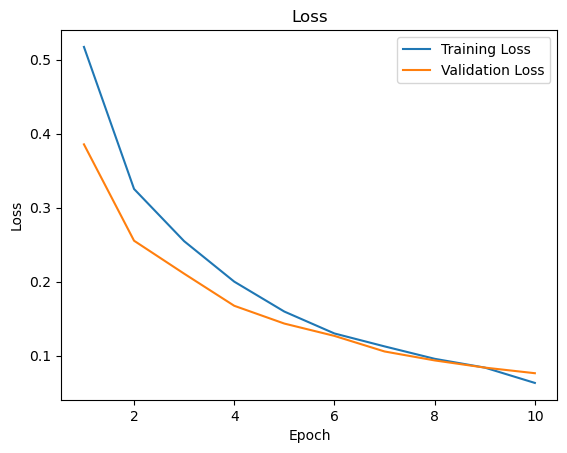

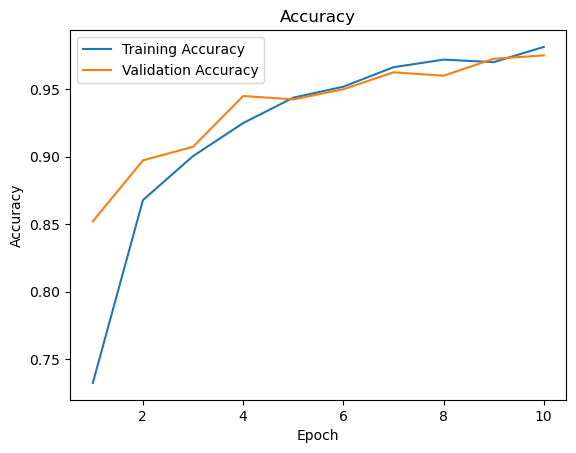

2025-05-16 02:48:26.661371: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 240244284 bytes after encountering the first element of size 240244284 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 305ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9699    0.9556    0.9627       135
           1     0.9774    0.9848    0.9811       264

    accuracy                         0.9749       399
   macro avg     0.9737    0.9702    0.9719       399
weighted avg     0.9749    0.9749    0.9749       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               16
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

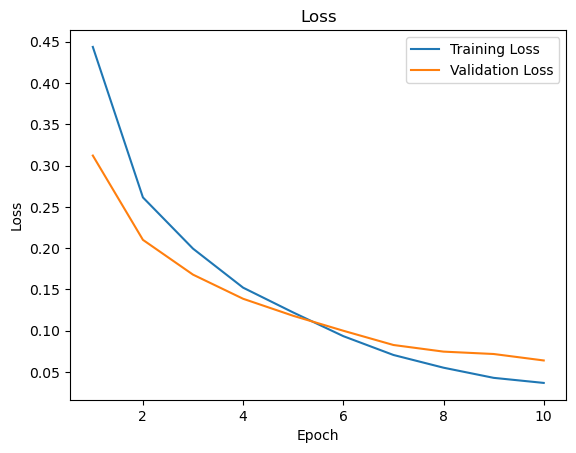

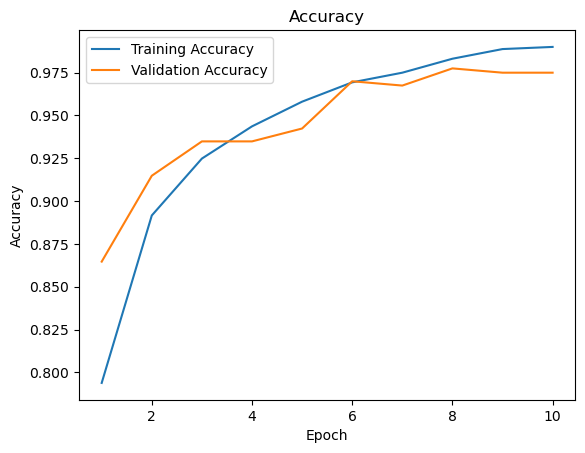

2025-05-16 02:49:35.344617: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 240244284 bytes after encountering the first element of size 240244284 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 306ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9699    0.9556    0.9627       135
           1     0.9774    0.9848    0.9811       264

    accuracy                         0.9749       399
   macro avg     0.9737    0.9702    0.9719       399
weighted avg     0.9749    0.9749    0.9749       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                                8
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

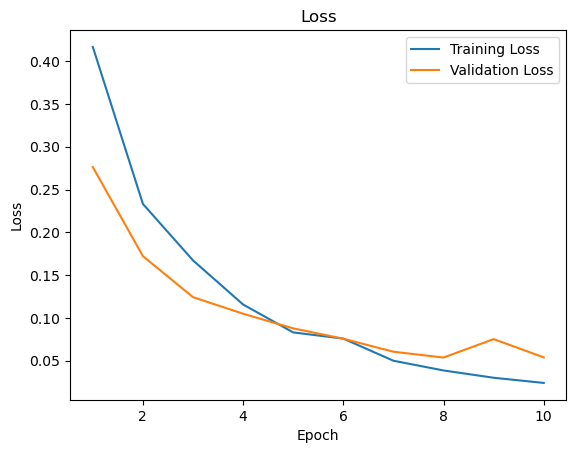

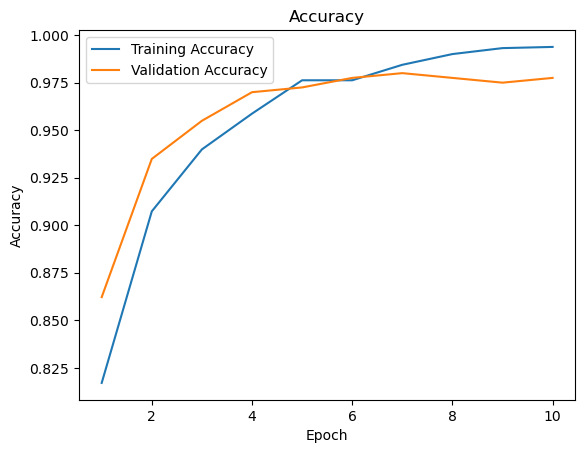

2025-05-16 02:50:59.305614: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 240244284 bytes after encountering the first element of size 240244284 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 293ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9632    0.9704    0.9668       135
           1     0.9848    0.9811    0.9829       264

    accuracy                         0.9774       399
   macro avg     0.9740    0.9757    0.9749       399
weighted avg     0.9775    0.9774    0.9775       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                                4
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

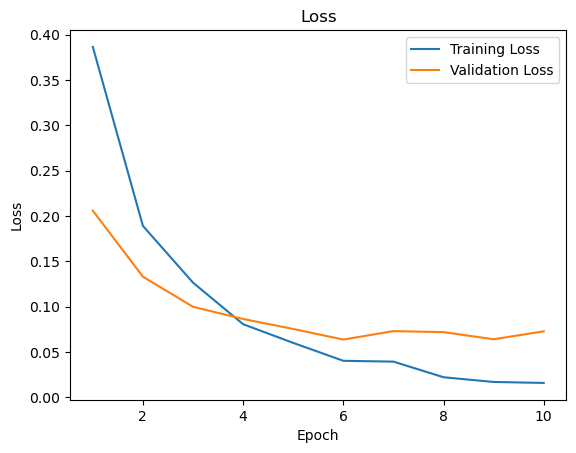

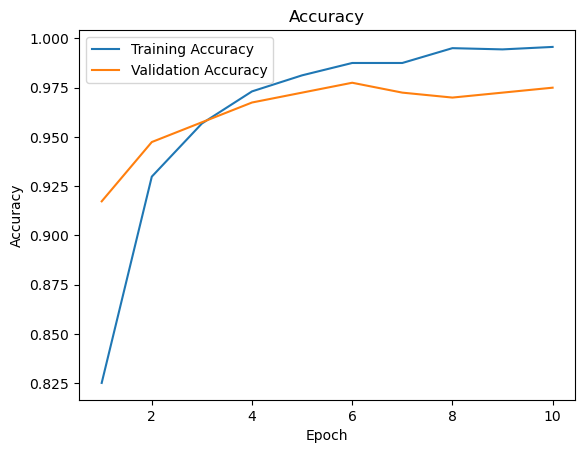

2025-05-16 02:52:28.863618: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 240244284 bytes after encountering the first element of size 240244284 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 303ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9921    0.9333    0.9618       135
           1     0.9669    0.9962    0.9813       264

    accuracy                         0.9749       399
   macro avg     0.9795    0.9648    0.9716       399
weighted avg     0.9754    0.9749    0.9747       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                                2
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

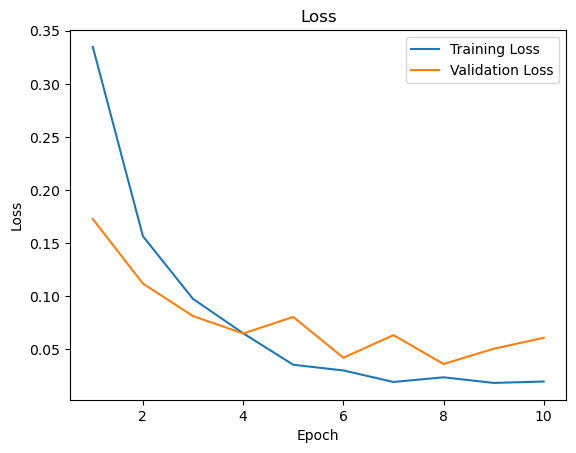

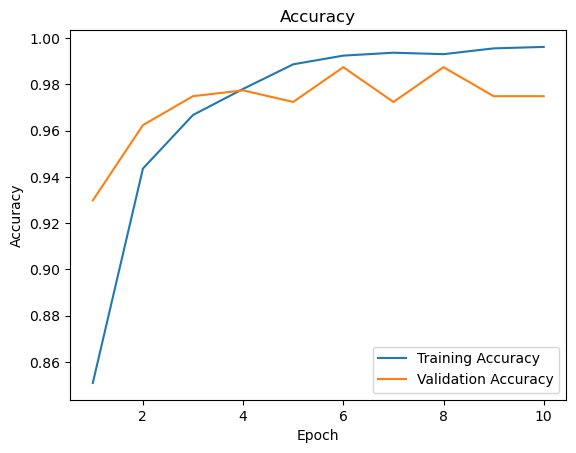

2025-05-16 02:54:36.738100: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 240244284 bytes after encountering the first element of size 240244284 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 301ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9921    0.9333    0.9618       135
           1     0.9669    0.9962    0.9813       264

    accuracy                         0.9749       399
   macro avg     0.9795    0.9648    0.9716       399
weighted avg     0.9754    0.9749    0.9747       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                                1
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

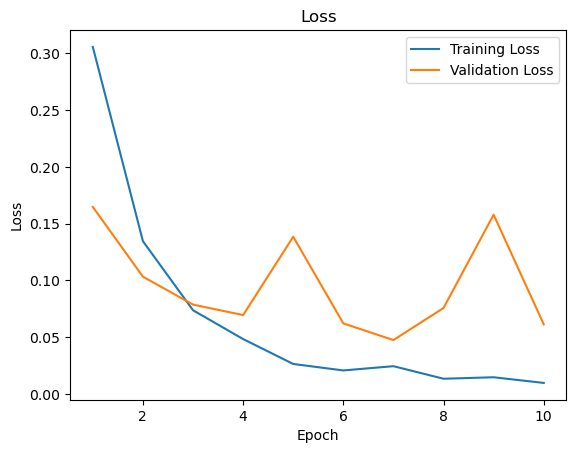

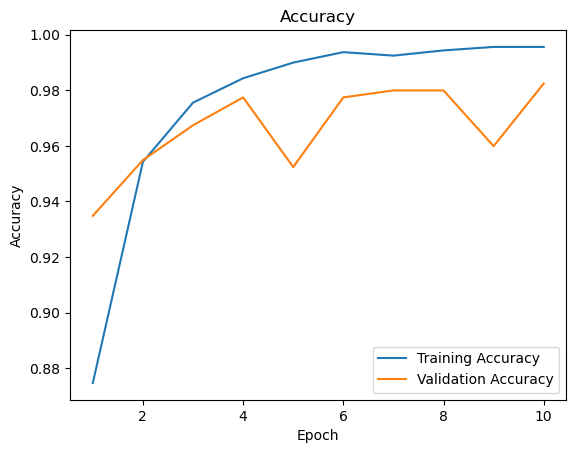

2025-05-16 02:58:05.802101: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 240244284 bytes after encountering the first element of size 240244284 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 321ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9776    0.9704    0.9740       135
           1     0.9849    0.9886    0.9868       264

    accuracy                         0.9825       399
   macro avg     0.9813    0.9795    0.9804       399
weighted avg     0.9824    0.9825    0.9824       399



In [11]:
for bs in [32, 16, 8, 4, 2, 1]:
    exp[f"batchsize_{bs}"] = run_experiment(
        experiment_name=f"batchsize_{bs}",
        data={"batch_size": bs},
        callbacks={"save_model": True},
    )

## Results

In [12]:
report_experiments(exp)

,Experiment,Category,Validation Accuracy,Validation Loss,Overfit Gap,NormLoss,Score
0,mag_40,Magnification,0.9649,0.0892,0.0243,0.0000,0.7054
1,mag_100,Magnification,0.9471,0.1425,0.0614,0.6066,0.1291
2,mag_200,Magnification,0.9403,0.1625,0.0641,0.8342,0.0414
3,mag_400,Magnification,0.9341,0.1770,-0.0014,1.0000,0.7500
4,baseline,Baseline,0.9699,0.0771,0.0107,0.0000,1.0000
5,block_6,Blocks,0.9900,0.0224,0.0174,0.1659,0.6285
6,block_5,Blocks,0.9875,0.0256,0.0153,0.2172,0.6883
7,block_4,Blocks,0.9950,0.0120,0.0095,0.0000,0.9492
8,block_3,Blocks,0.9799,0.0340,0.0090,0.3524,0.8772
9,block_2,Blocks,0.9875,0.0425,0.0292,0.4871,0.1282


,Category,Experiment,Validation Accuracy,Validation Loss,Overfit Gap
0,Baseline,baseline,0.9699,0.0771,0.0107
1,Batch Sizes,batchsize_2,0.9875,0.0359,0.0125
2,Blocks,block_4,0.9950,0.0120,0.0095
3,Dropouts,dropout_0.5,0.9649,0.1022,-0.0135
4,Learning Rate,lr_1e-05,0.8271,0.3752,-0.0195
5,Magnification,mag_400,0.9341,0.1770,-0.0014
6,Optimizers,optimizer_Adadelta,0.3860,0.7599,-0.0215


## Best Model
Test to see if the best in each set of experiments will produce a better performance


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                                2
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                4
model.blocks_to_unfreeze     :                             None
model.dropout_rate           :                             0.50
training.epochs              :                               50
training.learning_rate       :                             0.00
training.optimizer           :                             Adam
training.loss                :              binary_crossentropy
training.metrics             :        

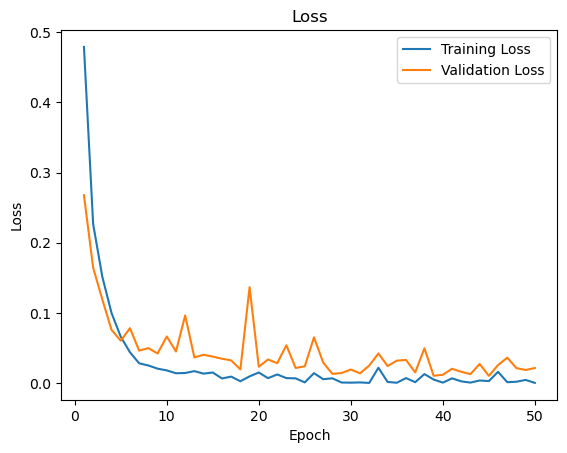

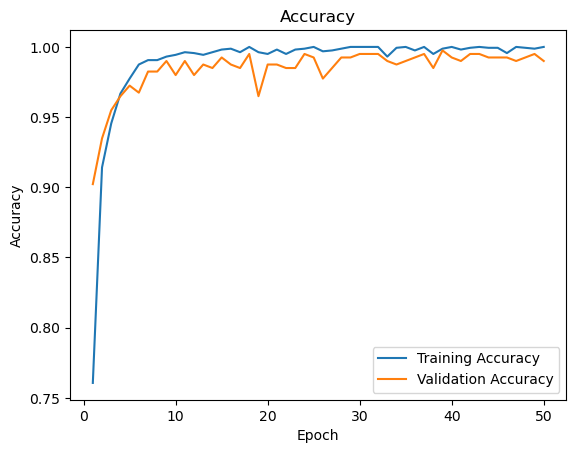

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 296ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9925    0.9778    0.9851       135
           1     0.9887    0.9962    0.9925       264

    accuracy                         0.9900       399
   macro avg     0.9906    0.9870    0.9888       399
weighted avg     0.9900    0.9900    0.9900       399



In [15]:
exp['best'] = run_experiment(
    data={
        'batch_size': 2
    },
    model={
        'unfreeze_blocks': 4,
        'dropout_rate': 0.5
    },
    training={
        'epochs': 50,
        'learning_rate': 1e-5,
        'optimizer': 'Adam'
    },
    callbacks={
        'save_model': True
    }
)


                        Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/400X
data.img_size                :                               224
data.batch_size              :                                 2
data.validation_split        :                              0.20
data.seed                    :                               123
model.backbone               :                    EfficientNetB0
model.pretrained             :                              True
model.unfreeze_blocks        :                                 4
model.blocks_to_unfreeze     :                              None
model.dropout_rate           :                              0.50
training.epochs              :                                30
training.learning_rate       :                              0.00
training.optimizer           :                          Adadelta
training.loss                :               binary_crossentropy
training.metrics       

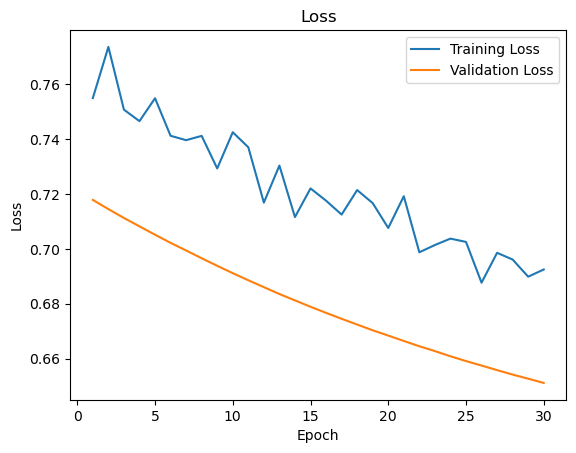

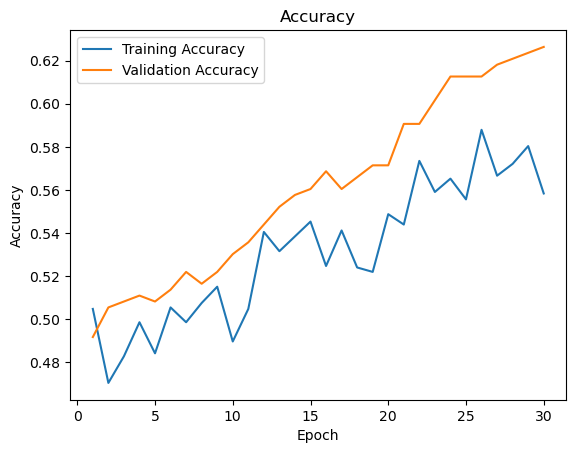

12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 474ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.4336    0.4050    0.4188       121
           1     0.7131    0.7366    0.7247       243

    accuracy                         0.6264       364
   macro avg     0.5734    0.5708    0.5717       364
weighted avg     0.6202    0.6264    0.6230       364



2025-05-16 03:32:25.120084: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
exp['best_based_from_table'] = run_experiment(
    data={
        'batch_size': 2,
        'data_dir': 'data/breakhis-dataset/binary/400X',
    },
    model={
        'unfreeze_blocks': 4,
        'dropout_rate': 0.5
    },
    training={
        'epochs': 30,
        'learning_rate': 1e-5,
        'optimizer': 'Adadelta'
    },
    callbacks={
        'save_model': True
    }
)